## a-AlphaBio homework problem
### Mark Thompson
### Started April 29, 2024 

#### scFv single-chain fragments of Pembrolizumab; which targets the programmed cell death protein 1 (PD-1) receptor of lymphocytes.
https://en.wikipedia.org/wiki/Pembrolizumab


In [1]:
%load_ext autoreload

In [2]:
%autoreload
# import libraries
import numpy as np
import pickle as pk
import pandas as pd
import math
import os
import torch
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append("../")

----
### Data set analysis
* remove rows with NAN for Kd (note: NAN may indicate a non-binding or very very poor binding event. I could impute a very high value for Kd for these cases.  I will ignore them in this first pass)

* also check for any Kd values < 0 (there were some in the dataset from the Nature paper)
* identify duplicate sequences and accumulate mean Kd values for these.
* for duplicates, take the Kd value as the mean of the Kd values over the duplicate sequences.  Caveat: eyeball these first to ensure the Kd values are NOT widely spread in value.

In [3]:
data_file = './data/alphaseq_data_train.csv'
df = pd.read_csv(data_file)
rows1 = df.shape[0]
print('starting dataframe has', rows1, 'rows')
print(df.columns.tolist())

starting dataframe has 30049 rows
['description_a', 'sequence_a', 'description_alpha', 'sequence_alpha', 'Kd', 'Kd_lower_bound', 'Kd_upper_bound', 'q_value']


In [4]:
# Remove Kd nans
#
df = df.dropna(subset=['Kd'])
rows2 = df.shape[0]
print('after removing nans, dataframe has', rows2, 'rows; (there were', rows1-rows2, 'rows with Kd=nan)')

after removing nans, dataframe has 29358 rows; (there were 691 rows with Kd=nan)


In [5]:
# Do I need to remove Kd vals that are negative?
#
num_negatives = (df[df['Kd'] > 0]).shape[0] - rows2
print('There are', num_negatives, 'Kd values < 0')

There are 0 Kd values < 0


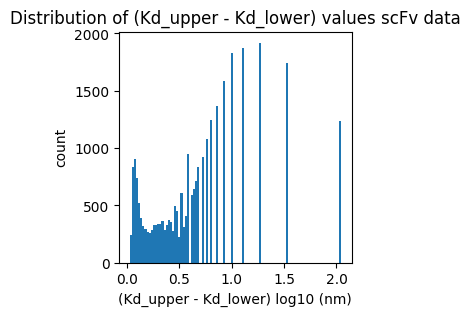

In [6]:
# Get the Kd,Kd_lower_bound,Kd_upper_bound columns
#
deltas = df['Kd_upper_bound'] - df['Kd_lower_bound']
qvals = df['q_value']
plt.figure(figsize=(3,3))
plt.hist(deltas, bins=100)
plt.xlabel('(Kd_upper - Kd_lower) log10 (nm)')
plt.ylabel('count')
plt.title('Distribution of (Kd_upper - Kd_lower) values scFv data')
plt.show()

df shape: (29358, 8)


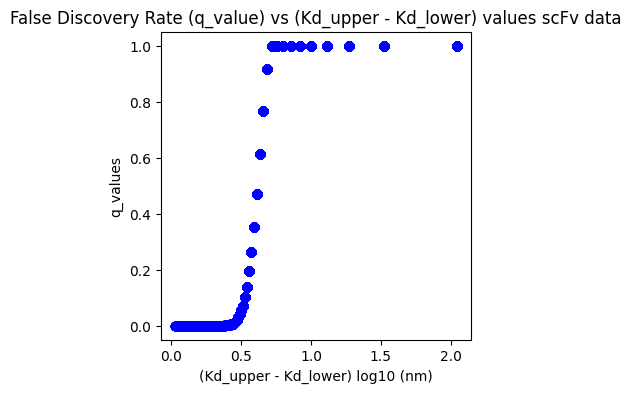

In [7]:
# Scatter plot of q_value vs (Kd_upper - Kd_lower)
#
print('df shape:', df.shape)
plt.figure(figsize=(4,4))
plt.scatter(deltas, qvals, c ="blue")
plt.xlabel('(Kd_upper - Kd_lower) log10 (nm)')
plt.ylabel('q_values')
plt.title('False Discovery Rate (q_value) vs (Kd_upper - Kd_lower) values scFv data')
# plt.xlim(0, 5)
# plt.ylim(0, 5)
plt.show()


df shape: (29358, 8)


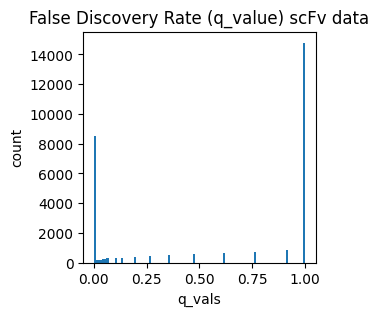

In [8]:
qvals = df['q_value']
print('df shape:', df.shape)
plt.figure(figsize=(3,3))
plt.hist(qvals, bins=100)
plt.xlabel('q_vals')
plt.ylabel('count')
plt.title('False Discovery Rate (q_value) scFv data')
plt.show()

In [9]:
# Remove rows with q_values > 0.5  
#
df = df[df['q_value'] <= 0.5]
print('number of rows after culling q_value > 0.5:', df.shape)

number of rows after culling q_value > 0.5: (12384, 8)


In [10]:
# Identify duplicate sequences and process their multiple Kd values
#
seqs = {} # will contain a list for binding energies for each unique sequence
for index, row in df.iterrows():
    seq = row['sequence_a']
    affinity = row['Kd']
    if seq not in seqs:
        seqs[seq] = list()
        seqs[seq].append(affinity)
    else:
        seqs[seq].append(affinity)

print('Number of unique sequences:', len(seqs))
print('First few entries')
for i, (k, v) in enumerate(seqs.items()):
    assert len(v) > 0, 'empty set for sequence'
    print(i, ':', 'num values:', len(v), ', values:', v)
    if i > 2:
        break

Number of unique sequences: 12320
First few entries
0 : num values: 51 , values: [1.2419628532129607, 1.3793547618634392, 1.1528594007742932, 1.1234871650658107, 1.161712868152616, 1.2252489460847826, 1.14559440926973, 1.128879976800924, 1.7984106042189367, 1.230264572870599, 1.1621030996620227, 2.088821673811601, 1.3130583571705543, 1.2244431358569834, 1.07105556422146, 1.2743967956448543, 1.8403837615756624, 1.1809028058854487, 1.2259335606406836, 1.3874729233398604, 1.0762728869166516, 1.4316441320626296, 1.2952890150171044, 1.3216025753034089, 1.2125037883629624, 1.1203545820858132, 1.3599596604472983, 1.1974700981104824, 1.3800538510679736, 1.2916007065814554, 1.2630263933743286, 1.2375541773776035, 1.1098785336541042, 1.7517630817399734, 1.0187118584110166, 1.1040702794938184, 1.3817934595452217, 1.3580189710309725, 1.123542623094604, 1.0643779140832734, 1.61937429500583, 2.1767792021213417, 1.141271146637056, 1.8645551415983483, 1.3440541152050225, 1.296708623038473, 1.410295033

In [11]:
# Calc the mean Kd for all unique sequences:
# calc the mean of the binding affinities for each sequence
seqs_mean_Kd = {}
for k,v in seqs.items():
    seqs_mean_Kd[k] = np.mean(v)

# Is there a distribution of lengths for scFv ?
s = set([len(k) for k,v in seqs_mean_Kd.items()])
print('Total number of different sequence lengths:', len(s), ', and it is', s, 'aa residues long')

Total number of different sequence lengths: 1 , and it is {246} aa residues long


In [12]:
# calc binding free energy (in kcal/mol) from Kd 
# affinity is Kd in nM
R = 1.98722 # cal/(mol*K)
T = 298.15 # K
def delta_G(Kd):
    delG = R * T * math.log10(Kd * 1e-9)    # or -RT log10(Ka)
    return delG/1000


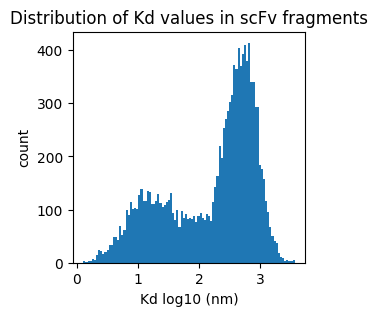

In [13]:
# Histogram of Kd values
#
kds = [v for k,v in seqs_mean_Kd.items()]
plt.figure(figsize=(3,3))
plt.hist(kds, bins=100)
plt.xlabel('Kd log10 (nm)')
plt.ylabel('count')
plt.title('Distribution of Kd values in scFv fragments')
plt.show()


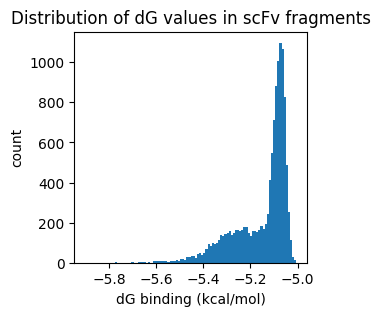

In [14]:
# Histogram of dG binding values
#
kds = [delta_G(v) for k,v in seqs_mean_Kd.items()]
plt.figure(figsize=(3,3))
plt.hist(kds, bins=100)
plt.xlabel('dG binding (kcal/mol)')
plt.ylabel('count')
plt.title('Distribution of dG values in scFv fragments')
plt.show()


mutations start at position 29 and end at position 108
length of mutation region: 80
min mutation frequency: tensor(0.)
max mutation frequency: tensor(0.0015)


(0.0, 1.1)

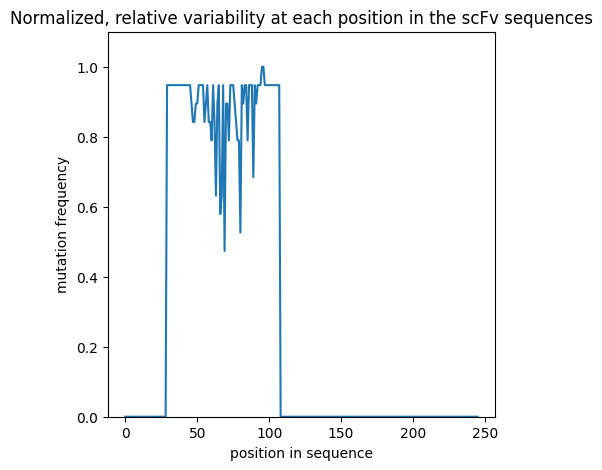

In [15]:
# Get a sense of the frequency of variability in each aa position in the scFv sequences
#
aa_sets = [set() for i in range(246)]

for k,v in seqs_mean_Kd.items():
    for i in range(len(k)):
        aa_sets[i].add(k[i])

# subtract 1 to account for the conserved aa positions that never change
counts = [len(x)-1 for x in aa_sets] 

# find first index where counts is > 0
firstIdx = next(x for x, val in enumerate(counts) if val != 0)
# and when it drops to 1 again
lastIdx = firstIdx + next(x for x, val in enumerate(counts[firstIdx:]) if val == 0)

# Mutations occur in a CDR region
print('mutations start at position', firstIdx, 'and end at position', lastIdx)
print('length of mutation region:', lastIdx-firstIdx+1)

# Absolute mutation frequency for each position in the aa sequence
mut_freq = torch.tensor([i/len(seqs_mean_Kd) for i in counts])
print('min mutation frequency:', torch.min(mut_freq))
print('max mutation frequency:', torch.max(mut_freq))

# Normalize the relative mutation frequency [0,1]
mut_freq = mut_freq/torch.max(mut_freq)

plt.figure(figsize=(5,5))
plt.plot(mut_freq)
plt.xlabel('position in sequence')
plt.ylabel('mutation frequency')
plt.title('Normalized, relative variability at each position in the scFv sequences')
# plt.xlim(20, 110)
plt.ylim(0, 1.1)

In [ ]:
print(len(mut_freq))
print(mut_freq)

# plt.xlim(20, 110)
# plt.ylim(0, 20)
# pk.dump(norm_counts, open('norm_counts.pkl', 'wb'))

In [ ]:
norm_counts = [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.75, 0.9, 0.9, 0.95, 0.95, 0.95, 0.9, 0.95, 0.95, 0.85, 0.55, 0.5, 0.25, 0.35, 0.3, 0.6, 0.45, 0.55, 0.95, 0.8, 0.8, 0.8, 0.9, 0.75, 0.8, 0.6, 0.95, 0.85, 0.35, 0.9, 0.85, 0.15, 0.4, 0.9, 0.3, 0.9, 0.8, 0.5, 0.95, 0.95, 0.95, 0.9, 0.6, 0.6, 0.75, 0.3, 0.85, 0.4, 0.9, 0.95, 0.4, 0.9, 0.95, 0.9, 0.25, 0.75, 0.55, 0.85, 0.25, 0.75, 0.6, 0.65, 0.8, 0.8, 0.95, 0.95, 0.85, 0.8, 0.8, 0.9, 0.7, 0.9, 0.9, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
print(len(norm_counts))
plt.plot(norm_counts)

### Create train/val/test split  (80/10/10)

In [ ]:
# Create the train and test sets and save as csv files
seqs = [k for k,v in seqs_mean_Kd.items()]
kds  = [v for k,v in seqs_mean_Kd.items()]

df_out = pd.DataFrame({'sequence_a': seqs, 'Kd': kds})
print('df_out shape:', df_out.shape)

# Train/val/test split 80/10/10
df_train = df_out.sample(frac=0.80, random_state=42)
df1 = df_out.drop(df_train.index)
df_val = df1.sample(frac=0.5, random_state=42)
df2 = df1.drop(df_val.index)
df_test = df2
print('train:', df_train.shape, ', val:', df_val.shape, ', test:', df_test.shape)

# DON'T re-save the data, as it is already saved!!
# save to csv
df_train.to_csv('./data/q_cleaned_1_train_set.csv', index=False)
df_val.to_csv('./data/q_cleaned_1_val_set.csv', index=False)
df_test.to_csv('./data/q_cleaned_1_test_set.csv', index=False)


### Ensure that train and val sets show same qualitative bimodal shape like above

In [ ]:
# Histogram of Kd values
#
kds_train = df_train['Kd'].to_list()
kds_val = df_val['Kd'].to_list()
kds_test = df_test['Kd'].to_list()

fig, axs = plt.subplots(1, 3)
fig.suptitle('Distribution of Kd values in scFv fragments')
axs[0].hist(kds_train, bins=50)
axs[0].set_title('Train Data')

axs[1].hist(kds_val, bins=50)
axs[1].set_title('Validation Data')

axs[2].hist(kds_test, bins=50)
axs[2].set_title('Test Data')

for ax in axs.flat:
    ax.set(xlabel='Kd log10 (nm)')




----
### The holdout dataset

In [ ]:
# The holdout data
data_file = './data/alphaseq_data_hold_out.csv'
df = pd.read_csv(data_file)
rows1 = df.shape[0]
print('holdout dataframe has', rows1, 'rows')
print(df.columns.tolist())
print(df['sequence_a'].describe())

In [ ]:
# Calc how many unique string lengths of sequence_a column there are
s = set([len(k) for k in df['sequence_a']])
print('Total number of different sequence lengths:', len(s), ', and they are', s, 'aa residues long')
# get the count of each length
df['sequence_a'].apply(len).value_counts()

----
### Examine other data that may be added as input channels to Vision Transformer.

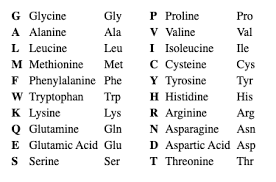

In [ ]:
# Classify the amino acids into their usual groups
# polar, nonpolar, positively charged, negatively charged, or none (i.e. CLS, SEP, PAD)
#
# 20 naturally occuring amino acids in human proteins plus MASK token, 
# 'X' is a special token for unknown amino acids, and CLS token is for classification, and PAD for padding
chars = ['CLS', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'X', 'MASK', 'PAD']
groups= ['none', 'nonpolar', 'nonpolar', 'neg', 'neg', 'nonpolar', 'nonpolar', 'pos', 'nonpolar', 'pos', 'nonpolar', 'nonpolar', 'neg', 
         'nonpolar', 'neg', 'pos', 'polar', 'polar', 'nonpolar', 'nonpolar', 'polar', 'none', 'none', 'none']
print('\nvocabulary:', chars)

stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }

group_encodings = { 'none'    : int('00101000', base=2), 
                    'polar'   : int('00110011', base=2),
                    'nonpolar': int('11001100', base=2), 
                    'pos'     : int('01010101', base=2),
                    'neg'     : int('10101010', base=2)} 

print('group_encodings:', group_encodings)

# maps amino acid to group                     
s_to_grp = {ch:group_encodings[i] for ch,i in zip(chars, groups)} 
# maps encoded residue to group
i_to_grp = {stoi[ch]:group_encodings[i] for ch,i in zip(chars, groups)} 

print('\ns_to_grp:', s_to_grp)
print('\ni_to_grp:', i_to_grp)




In [ ]:
import torch
def _bin(x):
    return format(x, '08b')

def _make_img(x, shape=(48,48)):
    d = ''.join([_bin(x[i]) for i in x.numpy()])
    # turn d into a list of integers, one for each bit
    d = [int(x) for x in d]    
    t = torch.tensor(d[:(shape[0]*shape[1])], dtype=torch.float32) # this is for 46,46 matrix
    t = t.reshape(shape)
    # t = t.unsqueeze(0) # add channel dimension
    return t


In [ ]:
# Since the residue encodings are spread over 8-bits, assign encodings to groups that spread across the 8-bits

none     = int('00101000', base=2)
polar    = int('00110011', base=2)
nonpolar = int('11001100', base=2)
pos      = int('01010101', base=2)
neg      = int('10101010', base=2)


In [ ]:
aa_chunk = 'QVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQGDEWMGGINPSNGGTNFNEKFKNRVTLTTDSSTTTAYMELKSLQFDDTAGYYCARRDYRFDMGFDYWGQGTTVTVSSGGGGSGGGGSGGGGSEIVLTQSPATLSLSPGERATLSCRASKGVSTSGYSYLHWYQQKPGQAPRLLIYLASYLESGVPARFSGSGSGTDFTLTISSLEPEDFAVYYCQHSRDLPLTFGGGTKVEIK'
print('length of aa_chunk:', len(aa_chunk))